In [1]:
from HeaderP import *
import pandas as pd

In [142]:
galah_apogee=pd.read_pickle('Data/GALAH_APOGEE_APOCAN.pkl').reset_index(drop=True)

In [43]:
sourceid=galah_apogee['sobject_id'].values


In [85]:
spec=np.zeros((len(sourceid),13))

from astropy.io import fits
spname='/Users/yl4331/Desktop/CreateDataTable/Data/GALAH_APOGEE_APOCAN_Spectra/'
for i in range(len(sourceid)):
    count=0
    spec[i,-1]=sourceid[i]
    for j in range(4):
        newspname=spname+str(int(sourceid[i]))+str(j+1)+'.fits'
        
        try:
            data=fits.open(newspname)[0]
            spec[i,count]=data.header['CRVAL1']
            spec[i,count+1]=data.header['CDELT1']*len(data.data)+spec[i,count]
            spec[i,count+2]=len(data.data)
            count=count+3
        except:
            spec[i,count]=np.nan
            spec[i,count+1]=np.nan
            spec[i,count+2]=np.nan
            count=count+3
        


In [86]:
useablespec=pd.DataFrame(spec).dropna().values
np.shape(useablespec)

(745, 13)

In [90]:
for i in range(13):
    print(max(useablespec[:,i]))

4712.431640625
4900.7544733478335
4096.0
5647.21435546871
5871.190423844779
4096.0
6476.16650390621
6734.878103417812
4096.0
7584.39892578121
7885.629173582504
4096.0
131123004101251.0


In [107]:
from scipy import interpolate
def interpolate_to_grid(xdata, ydata, xgrid):
    f = interpolate.interp1d(xdata, ydata)
    new_ydata= f(xgrid)
    return xgrid, new_ydata

In [110]:
wl=np.zeros((4096,4))
count=0
for i in range(4):
    wl[:,i]=np.linspace(max(useablespec[:,count]),min(useablespec[:,count+1]),4096)
    count=count+3

In [185]:
import scipy
fluxs=np.zeros((4096,4,np.shape(useablespec)[0]))
ivars=np.zeros((4096,4,np.shape(useablespec)[0]))
for i in range(np.shape(useablespec)[0]):
    spname='/Users/yl4331/Desktop/CreateDataTable/Data/GALAH_APOGEE_APOCAN_Spectra/'
    count=0
    for j in range(4):
        # read in spectra
        newspname=spname+str(int(useablespec[i,-1]))+str(j+1)+'.fits'
        
        # get what the old wl is
        wl_old=np.linspace(useablespec[i,count],useablespec[i,count+1],int(useablespec[i,count+2]))
        count=count+3
         
        # get old flux/ivar
        flux=fits.open(newspname)[0].data # load in unnormalized flux
        ivar=fits.open(newspname)[1].data*flux # load in ivar
        
        __, new_flux = interpolate_to_grid(wl_old, flux, wl[:,j]) # on common grid
        __, new_ivar = interpolate_to_grid(wl_old, ivar, wl[:,j]) # on common grid
        
        flux_norm = new_flux/scipy.ndimage.gaussian_filter1d(new_flux, 1087) # normalize flux
        ivar_norm = (new_ivar/flux_norm)**-2 # normalize ivar
        
        fluxs[:,j,i]=flux_norm
        ivars[:,j,i]=ivar_norm

In [186]:
tr_ID=useablespec[:,-1]
tr_flux=np.zeros((np.shape(useablespec)[0],4096*4))
tr_ivar=np.zeros((np.shape(useablespec)[0],4096*4))
wl_all=np.zeros(4096*4)


In [187]:
for i in range(4):
    wl_all[4096*i:4096*(i+1)]=wl[:,i]
    for j in range(len(tr_ID)):
        tr_flux[j,4096*i:4096*(i+1)]=fluxs[:,i,j]
        tr_ivar[j,4096*i:4096*(i+1)]=ivars[:,i,j]

In [188]:
# get training labels from APOGEE
# get the dataframe for labels
labels=galah_apogee.loc[pd.DataFrame(spec).dropna().index]

cannonage=pd.read_pickle('../SecondYear/CannonDR16.pkl')
labels=labels.merge(cannonage[['APOGEE_ID','Age','DP','Dnu']], left_on='APOGEE_ID',right_on='APOGEE_ID',how="inner")


labelnames=['M_H','TEFF','LOGG','MG_FE','DP','Dnu','Age']

tr_label=labels[labelnames].values


In [189]:
print(tr_ID.shape)
print(wl_all.shape)
print(tr_flux.shape)
print(tr_ivar.shape)
print(tr_label.shape)


(745,)
(16384,)
(745, 16384)
(745, 16384)
(745, 7)


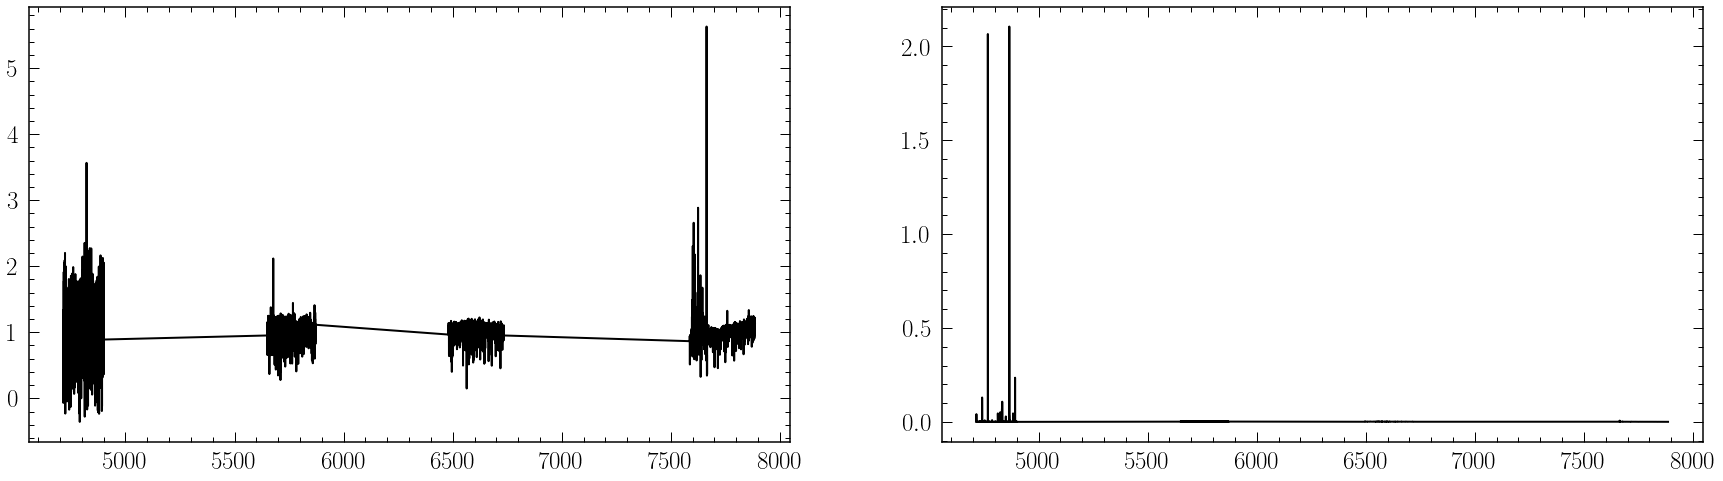

In [190]:
# plot one spectra
plt.figure(figsize=(30,8))
plt.subplot(1,2,1)
plt.plot(wl_all,tr_flux[0,:],'k-')

plt.subplot(1,2,2)
plt.plot(wl_all,tr_ivar[0,:],'k-')

In [191]:
test_ID = tr_ID
test_flux = tr_flux
test_ivar = tr_ivar


In [192]:
from TheCannon import dataset
ds = dataset.Dataset(wl_all, tr_ID, tr_flux, tr_ivar, tr_label, test_ID, test_flux, test_ivar)

Loading dataset
This may take a while...


In [193]:
ds.set_label_names(labelnames)

Diagnostic for SNRs of reference and survey objects


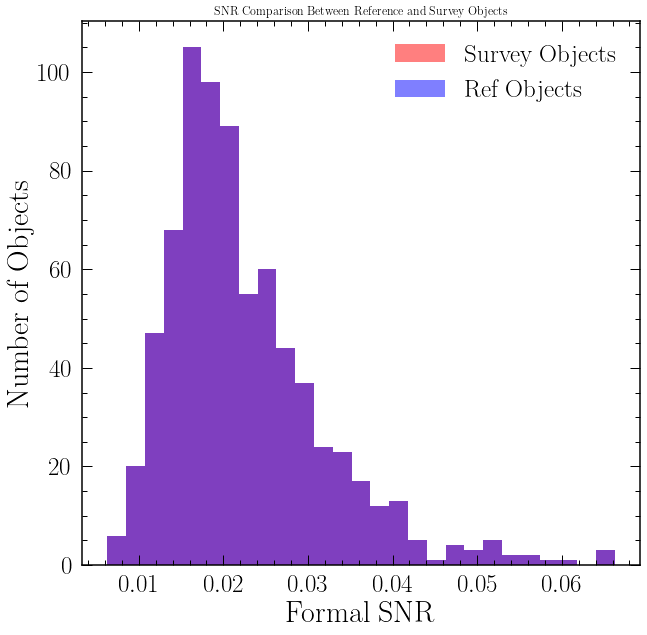

In [194]:
fig = ds.diagnostics_SNR()

In [176]:
from TheCannon import model
md = model.CannonModel(2, useErrors=False)
md.fit(ds)

Done training model. 


In [178]:
md.diagnostics_leading_coeffs(ds)
md.diagnostics_plot_chisq(ds)

Diagnostic plot: leading coeffs and scatters across wavelength.
Diagnostic plot: histogram of the red chi squareds of the fit
Saved as modelfit_chisqs.png


In [179]:
label_errs = md.infer_labels(ds)
test_labels = ds.test_label_vals
ds.diagnostics_1to1()

Inferring Labels
Diagnostic for label output vs. input
Saved fig 1to1_label_0.png
Diagnostic for label output vs. input
Saved fig 1to1_label_1.png
Diagnostic for label output vs. input
Saved fig 1to1_label_2.png
Diagnostic for label output vs. input
Saved fig 1to1_label_3.png
Diagnostic for label output vs. input
Saved fig 1to1_label_4.png
Diagnostic for label output vs. input
Saved fig 1to1_label_5.png
Diagnostic for label output vs. input
Saved fig 1to1_label_6.png
